# Menu <a class="anchor" id="menu"></a>
   
* [1. Préparation du jeu de données](#init)
    * [1.1 Séparation du jeu de données en `train`, `valid` et `test` sets](#NLP_split)
    * [1.2 Création du Corpus Bag-Of-Words](#NLP_corpus_bow)
    * [1.3 Création du Corpus TF-IDF](#NLP_corpus_tfidf)
* [2. Recherche d'un modèle de classification](#CLF)
    * [2.1 DummyClassifier](#CLF_dummy)
    * [2.2 LogisticRegression](#CLF_logreg)

In [1]:
import pathlib
import pandas as pd
import numpy as np
import joblib

random_seed = 0
np.random.seed(random_seed)

---
---
# 1. Préparation du jeu de données <a class="anchor" id="init"></a> [⇪](#menu)

In [2]:
data_nlp_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp.bin')
data_nlp = joblib.load(data_nlp_path)

In [3]:
display(data_nlp.head(2), data_nlp.shape)

,target,lemmas
1180586,1,"[omg, yes, yes, yes, watch]"
1471360,1,"[excuse, wii]"


(456560, 2)

In [4]:
data_nlp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456560 entries, 1180586 to 646681
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   target  456560 non-null  category
 1   lemmas  456560 non-null  object  
dtypes: category(1), object(1)
memory usage: 7.4+ MB


---
## 1.1 Séparation du jeu de données en `train`, `valid` et `test` sets <a class="anchor" id="NLP_split"></a> [⇪](#menu)

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
df_train, df_test, y_train, y_test = train_test_split(data_nlp.lemmas, data_nlp.target, test_size=0.2)

In [7]:
df_train.shape, df_test.shape, y_train.shape, y_test.shape

((365248,), (91312,), (365248,), (91312,))

---
## 1.2 Création des Corpus Bag-Of-Words <a class="anchor" id="NLP_corpus_bow"></a> [⇪](#menu)

Le `Corpus - Bag Of Word` contient une liste (un pour chaque document) de *term vectors* qui indiquent la fréquence de chaque mot du *vocabulaire*.

In [8]:
corpus_train = [" ".join(x) for x in df_train]
len(corpus_train)

365248

In [9]:
corpus_test = [" ".join(x) for x in df_test]
len(corpus_test)

91312

---
## 1.3 Création des Corpus TF-IDF <a class="anchor" id="NLP_corpus_tfidf"></a> [⇪](#menu)
Le `Corpus - TF-IDF` est une version *normalisée* du Bag-Of-Words pour éviter que des mots sans importance mais fréquents prennent trop d'importance.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer_train = TfidfVectorizer(use_idf=True, min_df=5, max_df=0.5)
X_train = tfidf_vectorizer_train.fit_transform(corpus_train)
display(tfidf_vectorizer_train.get_feature_names_out(), X_train.shape)

array(['aa', 'aaa', 'aaaa', ..., 'zzzzzzzzzz', 'ðº', 'ðºð'], dtype=object)

(365248, 14864)

In [11]:
X_test = tfidf_vectorizer_train.transform(corpus_test)
print(X_test.shape)

(91312, 14864)


---
---
# 2. Recherche d'un modèle de classification <a class="anchor" id="CLF"></a> [⇪](#menu)

#### Chargeons les fonctions de classification écrites sur les projets précédents

In [12]:
from classification_utils import fit_model, get_scores, init_scores

init_scores("data/scores_classique.csv")

#### Définissons une méthode de `cross-validation`

In [13]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

## 2.1 Établissons une base-line avec un algorithm naïf *(Dummy Classifier)* <a class="anchor" id="CLF_dummy"></a> [⇪](#menu)

In [14]:
from sklearn.dummy import DummyClassifier
import time

In [15]:
model_name = "DummyClassifier"

In [16]:
grd_dummy = fit_model( 
    DummyClassifier(),
    param_grid={ 'random_state':[random_seed], 'strategy':['stratified'] }, 
    cv = skfold,
    verbose=2,
    X_ref = X_train,
    y_ref = y_train,
)

/home/valkea/Dev/OpenClassrooms/Projets_AI/P7/venvP7/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5002
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5006
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.4983
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.4992
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.4977

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.4992 (std:0.0011)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- DummyClassifier --------------------------------------------------------------------------------

             ROC_AUC : 0.4995
                  F1 : 0.4956
            ACCURACY : 0.4995
           PRECISION : 0.4952
              RECALL : 0.4960
   AVERAGE_PRECISION : 0.4955

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.50      0.50      0.50     46044
Prediction = 1       0.50      0.50      0.50     45268

      accuracy                           0.50     91312
     macro avg       0.50      0.50      0.50     91312
  weighted avg       0.50  

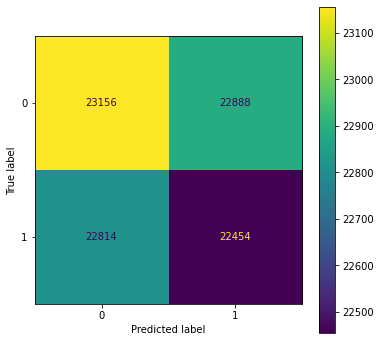

--- ROC AUC ---------------------------------------------------------------------------------------- 



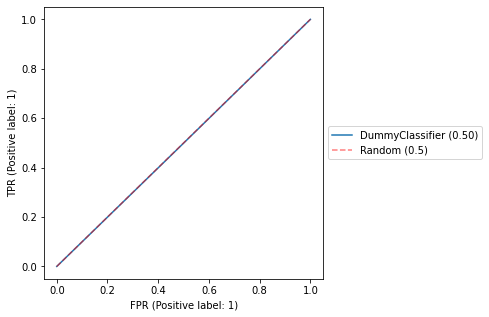

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



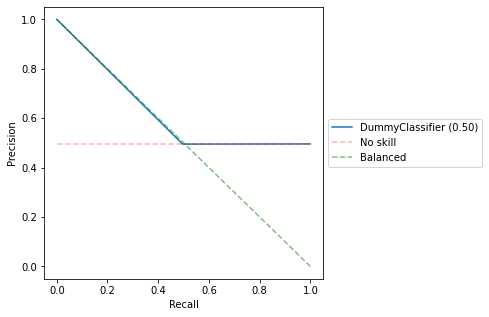

In [17]:
get_scores(model_name, **grd_dummy, register=True, X_ref=X_test, y_ref=y_test)

In [18]:
del grd_dummy

## 2.2 Essayons un algorithme linéaire - Logistic Regression <a class="anchor" id="CLF_logreg"></a> [⇪](#menu)

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
from scipy.stats import uniform, loguniform

In [21]:
max_lr_iter = 3000
param_grid = [
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : loguniform(1e-5, 1e2),
    },
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : loguniform(1e-5, 1e2),
    },
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['saga'],
        'penalty' : ['elasticnet'], # none
        'C' : loguniform(1e-5, 1e2),
        'l1_ratio' : uniform(0,1)
    },
]

In [22]:
model_name = "Basic LogisticRegression"
max_lr_iter = 3000

grd_log = fit_model(
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold,
    X_ref = X_train,
    y_ref = y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7684
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7668
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7682
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7661
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7686

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7676 (std:0.0011)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic LogisticRegression -----------------------------------------------------------------------

             ROC_AUC : 0.8291
                  F1 : 0.7537
            ACCURACY : 0.7502
           PRECISION : 0.7372
              RECALL : 0.7711
   AVERAGE_PRECISION : 0.8206

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.76      0.73      0.75     46044
Prediction = 1       0.74      0.77      0.75     45268

      accuracy                           0.75     91312
     macro avg       0.75      0.75      0.75     91312
  weighted avg       0.75  

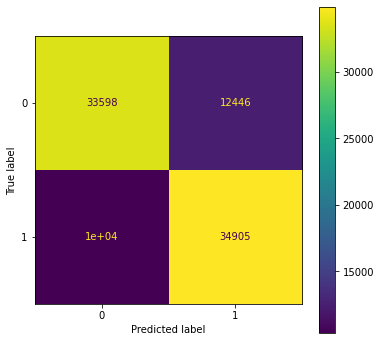

--- ROC AUC ---------------------------------------------------------------------------------------- 



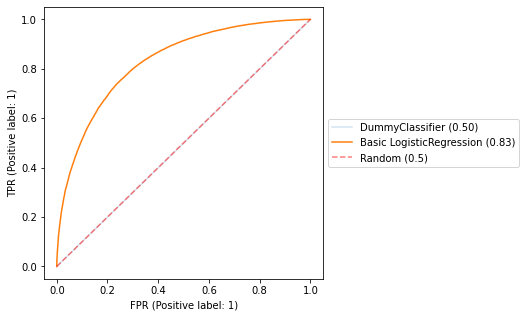

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



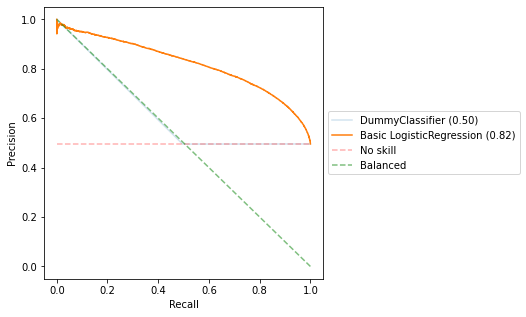

In [23]:
get_scores(model_name, **grd_log, register=True, X_ref=X_test, y_ref=y_test)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [24]:
del grd_log

In [ ]:
import FreeMobileSMS as sms
sms.send()